In [ ]:
%config IPCompleter.greedy=True

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

traning_sentences = []
training_labels = []

testing_sequences = []
testing_labels = []

for s,l in train_data:
  traning_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s,l in test_data:
  testing_sequences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

2022-04-16 15:53:42.359591: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-16 15:53:42.360158: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_token = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(traning_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(traning_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(testing_sequences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [13]:
import tensorflow as tf

embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 659,213
Trainable params: 659,213
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(padded, training_labels_final, epochs=4, validation_data=(test_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/4


2022-04-16 16:16:40.924558: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_gru_145303_145864_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_146034' and '__inference___backward_cudnn_gru_with_fallback_144386_144527' both implement 'gru_a315ad41-5f15-43d7-b6aa-1bcb4720e316' but their signatures do not match.


24992/25000 [============================>.] - ETA: 0s - loss: 0.4926 - accuracy: 0.7412

2022-04-16 16:23:27.233311: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_148992_specialized_for_sequential_2_bidirectional_1_backward_gru_1_StatefulPartitionedCall_at___inference_distributed_function_149299' and '__inference_standard_gru_148992' both implement 'gru_1f11bbe8-823e-479c-b67a-8efdd217b0e3' but their signatures do not match.


25000/25000 [==============================] - 517s 21ms/sample - loss: 0.4928 - accuracy: 0.7410 - val_loss: 0.3533 - val_accuracy: 0.8467
Epoch 2/4
25000/25000 [==============================] - 884s 35ms/sample - loss: 0.2882 - accuracy: 0.8835 - val_loss: 0.3514 - val_accuracy: 0.8498
Epoch 3/4
25000/25000 [==============================] - 914s 37ms/sample - loss: 0.2050 - accuracy: 0.9222 - val_loss: 0.4023 - val_accuracy: 0.8373
Epoch 4/4
25000/25000 [==============================] - 930s 37ms/sample - loss: 0.1285 - accuracy: 0.9530 - val_loss: 0.4733 - val_accuracy: 0.8267


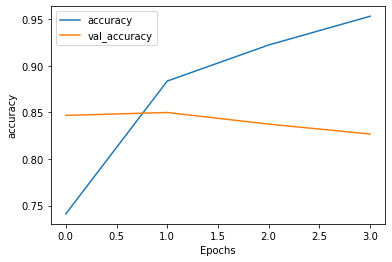

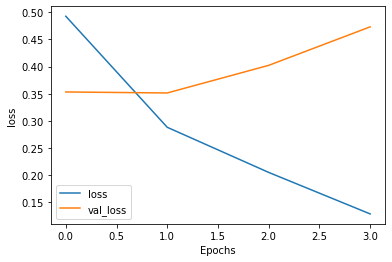

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')